# Supervised Machine Learning - Predict whether a song is positive or not

---


### Project Topic:

This projects goal is to use classification supervised machine learning algorithms to determine if a song is positive or not based on a set of given features. This is a classification problem.

The motivation behind this project is to be able to predict whether a song is considered positive without reading the lyrics - and this can be used to ensure that you are only listening (and therefore influenced) by positive songs.



---


# Data:

The data is from a public Kaggle dataset, "Most Streamed Spotify Songs 2023". Here is the source in APA format: *Elgiriyewithana, N. (2023). Most Streamed Spotify Songs 2023. Retrieved from https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/data*

#### Let's do some data description and exploration with code

In [41]:
# Get the data and do a very basic overview

import pandas as pd
import numpy as np

song_data = pd.read_csv("./spotify-2023.csv", encoding="ISO-8859-1")
print(song_data.describe())
song_data.columns



       artist_count  released_year  released_month  released_day  \
count    953.000000     953.000000      953.000000    953.000000   
mean       1.556139    2018.238195        6.033578     13.930745   
std        0.893044      11.116218        3.566435      9.201949   
min        1.000000    1930.000000        1.000000      1.000000   
25%        1.000000    2020.000000        3.000000      6.000000   
50%        1.000000    2022.000000        6.000000     13.000000   
75%        2.000000    2022.000000        9.000000     22.000000   
max        8.000000    2023.000000       12.000000     31.000000   

       in_spotify_playlists  in_spotify_charts  in_apple_playlists  \
count            953.000000         953.000000          953.000000   
mean            5200.124869          12.009444           67.812172   
std             7897.608990          19.575992           86.441493   
min               31.000000           0.000000            0.000000   
25%              875.000000          

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

#### Data description

* There are 953 samples / rows
* There are 24 features / columns
* 7 feature / columns are categorical and 17 are numerical
* Key numerical column is valence_%, since we will consider valence score > 50 as positive songs. Description of valence is "Positivity of the song's musical content"




---

# Data Cleaning

By looking at a sample of 50 data, the data appears to be high quality already with very little or no missing data.

If we check for missing values for the `in_shazam_charts` column, we find 50 cells with missing values. We'll assume this means that there are 0 streams in shazam and will fill the cell with 0.

We will also drop categorical columns, since they contain information we don't want to use in predictions (like the artist).

In [42]:
# Check how many values are missing, fill them with a default, and remove categorical features

song_data[song_data['in_shazam_charts'].isna()]
song_data = song_data.fillna({'in_shazam_charts': 0})
song_data = song_data.select_dtypes(include=[np.number])

Next, we will drop the categorical features - since we want to predict whether a song is positive or not based on the song content and not things like the artist

Next, let's add a target column to determine whether or not a song should be considered positive or not. Let's check the distribution of positivity (using the `valence_%` column)



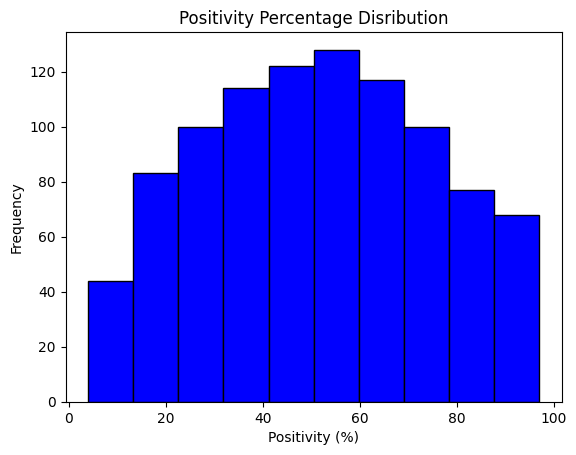

In [43]:
# Histogram of positivity %
import matplotlib.pyplot as plt

plt.hist(song_data['valence_%'], color='blue', edgecolor='black')
plt.title('Positivity Percentage Disribution')
plt.xlabel('Positivity (%)')
plt.ylabel('Frequency')
plt.show()

It seems that the distribution is normally distributed, so we won't need to do further data processing.

However, we still need to create a target column to classify whether a song is positive or not. Let's create a new column `is_positive` that is true if the `valence_%` column is above 50%

In [44]:
# create the target feature
song_data['is_positive'] = (song_data['valence_%'] > 50 ).astype(int)

Now that we've created the `is_positive` column, we can drop the `valence_%` column. We droppped it because otherwise the `valence_%` column would predict the positivity to a very high degree

In [45]:
# remove the positivity / valence %, since it will be highly correlated to the target feature
song_data = song_data.drop('valence_%', axis=1)

# Exploratory Data Analysis

---

Let's look at features that could seem highly correctly to positivity. For example, high energy levels could also indice being positive.[link text](https://)




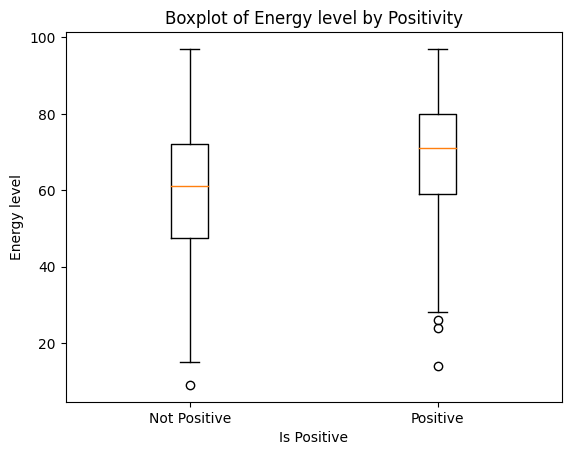

In [46]:
# Create a boxplot of positive classification and energy levels
plt.boxplot([song_data[song_data['is_positive'] == 0]['energy_%'],
             song_data[song_data['is_positive'] == 1]['energy_%']],
            labels=['Not Positive', 'Positive'])
plt.title('Boxplot of Energy level by Positivity')
plt.xlabel('Is Positive')
plt.ylabel('Energy level')
plt.show()


Comparing the box plot of a positive and not positive song, we see that they are pretty similar, with the postiive songs having about 10% higher energy levels. We also notice that the data is distributed well for both as the central tendency line seems to be in the middle of both box plots.

We can look at another feature that might have high correlation, danceability:

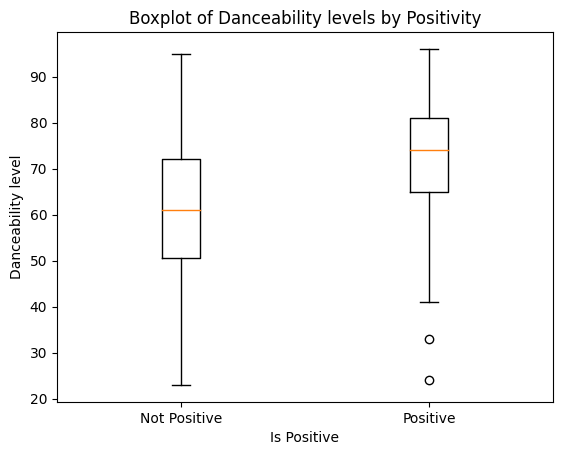

In [47]:
# Create a boxplot of positive classification and danceability
plt.boxplot([song_data[song_data['is_positive'] == 0]['danceability_%'],
             song_data[song_data['is_positive'] == 1]['danceability_%']],
            labels=['Not Positive', 'Positive'])
plt.title('Boxplot of Danceability levels by Positivity')
plt.xlabel('Is Positive')
plt.ylabel('Danceability level')
plt.show()

By looking at the box plot, we can see that the average positive song is 15% higher than not positive songs, and the length of the box plot is noticeably smaller for positive songs - this means that the range of danceability is smaller for positive songs for the interquartile range.

Next up we'll do a correlation matrix to identify any relationships and check for any multicollinearity between features

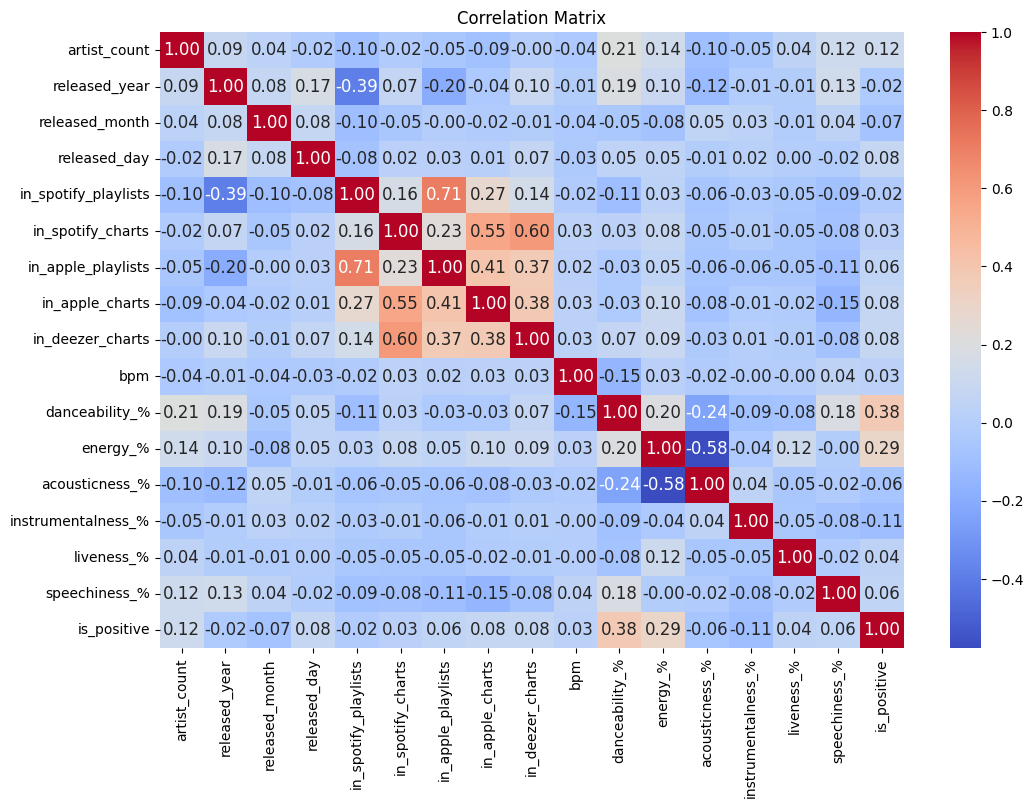

In [48]:
# Create a correlation matrix to review multicollinearity between features
import seaborn as sns
corr_matrix = song_data.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 12})
plt.title('Correlation Matrix')
plt.show()

Taking a look at the correlation matrix for the `is_positive` feature, we can see that the danceability and energy features are the only features that are slightly correlated with being positive (all other features are below 0.1 percent correlation).

#### EDA conclusion

Given these findings, it's likely that danceability and energy levels could be good predictors for whether a song is positive or not - and all other features are not useful predictors. However, it's important to note that the correlation is not super strong and further investigation is needed. In addition, since it seems like there are only two feature / columns that have an impact, there is no need to use a model like random forest to find which features to use.



---
# **Models**

In terms of choosing the model, since there are only 17 numerical features and less than 1000 rows, we want to choose a simple models that is not prone to overfitting. So we will not use SVM models.

Since we are trying to classify if a song is positive or not, we will use classification supervised machine learning algorithms.

But before we do that, let's create a test and training data set

In [49]:
# Create test and train data sets
from sklearn.model_selection import train_test_split

X = song_data.iloc[:,:-1]
y = song_data['is_positive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Now let's create a Logistic Regression model with 1000 iterations - since I tried it with 100 iterations and it gave a warning that it was not complete.

In [50]:
# create a logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6910994764397905

Accuracy is 0.69%. We are using accuracy since the data is balanced. Let's try using a different solver to see if that improves performance

In [51]:
# try to create a new logistic regression with a different solver
logistic_model_solver = LogisticRegression(max_iter=10000, solver='saga')
logistic_model_solver.fit(X_train, y_train)

y_pred_solver = logistic_model_solver.predict(X_test)

accuracy_solver = accuracy_score(y_test, y_pred_solver)
accuracy_solver

0.643979057591623

Using the saga solver, we scored a worse accuracy (by 5%), so we'll stick with the default solver.

Now, let's use gridsearch to find the best hyperparameters

In [52]:
# fine tune the hyper parameters for the logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 2, 3, 4,4.5, 5, 10]}

grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'C': 4}, 0.7192208462332301)

The best C parameter / regularization strength is 4 with accuracy of 0.72.

Now let's use a more robust that takes into account the relevance of features and is robust against multicollinearity. Let's use XGBoost.

In [53]:
#Create XGBoost model
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, subsample=0.7, max_depth=3, learning_rate=0.1 ,seed=42)

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
accuracy

0.7486910994764397

Let's use gridsearch to tune the hyperparameters

In [54]:
# Tune the hyperparameters of the grid search
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', seed=42), param_grid_xgb, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 3 folds for each of 81 candidates, totalling 243 fits


({'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7},
 0.7427821522309711)

The best parameters according to the gridsearch are:

`{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}`

The accuracy is 0.7427821522309711 which is greater than the accuracy for the logistic regression model.



---

# Results and Analysis

We used two ML models to try and predict whether a song is positive or not. The XGBoost model had an accuracy of 0.74, and the hyper parameters were fine tuned using GridSearch - and the Logistic Regression scored slightly lower with an accuracy of 0.71.

Let's look more into the results for the XGBoost model by using a classification report


In [55]:
# create a classification report
from sklearn.metrics import classification_report

class_report_logistic = classification_report(y_test, y_pred)
class_report_xgb = classification_report(y_test, y_pred_xgb)

print("Logistic Regression Classification report: ", class_report_logistic)
print("XGBoost Classification report: ", class_report_xgb)


Logistic Regression Classification report:                precision    recall  f1-score   support

           0       0.74      0.64      0.68       100
           1       0.65      0.75      0.70        91

    accuracy                           0.69       191
   macro avg       0.69      0.69      0.69       191
weighted avg       0.70      0.69      0.69       191

XGBoost Classification report:                precision    recall  f1-score   support

           0       0.78      0.72      0.75       100
           1       0.72      0.78      0.75        91

    accuracy                           0.75       191
   macro avg       0.75      0.75      0.75       191
weighted avg       0.75      0.75      0.75       191



Let's create a confusion matrix for both models

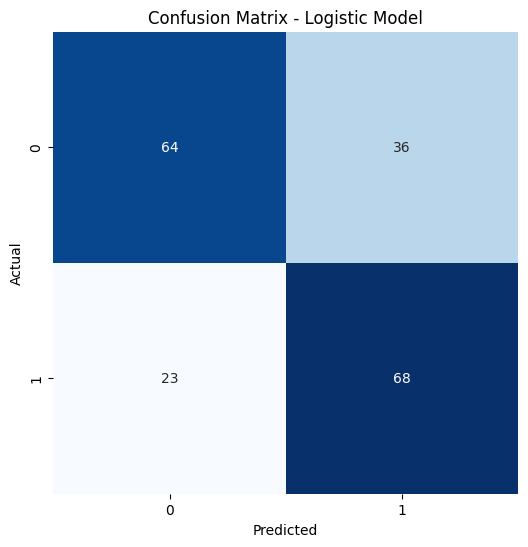

In [56]:
# Create a confusion matrix for the logistic regression model
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Model')

plt.show()

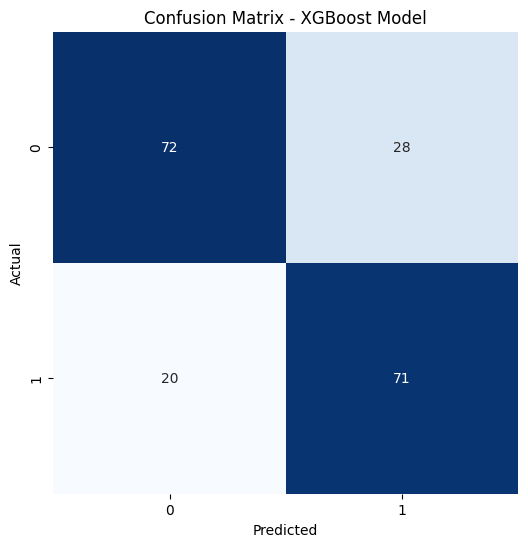

In [57]:
# Create a confusion matrix for the XGBoost model
conf_mat = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Model')

plt.show()

As we discussed earlier - the XGBoost model performs slightly better than the Logistic Regression model. This slight perform increase is further shown in the confusion matrix's, where we can see the XGBoost model predicted the correct values slightly more than the Logistic Regression model.

Since we used GridSearch, we used the optimal hyperparameters and there is no further iteration possible.



---

# Discussion

#### Learnings

Some things that I learned is that data cleaning is very important. Initially, I did not drop the categorical features - so when I reached the point of building classification models, they did not work with the categorical features.

#### Discussion for why something didn't work

I think a reason why the models did not perform better is because the two features which had the highest correlation and most impact (danceability and energy levels) are somewhat subjective and not objective.

This subjectivity introduce variability to the model predictions. And, as more data is collected, this subjectivity might skew the data even more.

#### Discussion for improvement

I think we can improve the model by acquiring a larger dataset. We only had around 900 samples to work with. In addition, I think we could have tried to find a dataset with more features since only two features (danceability and energy levels) had a correlation with positivity above 10%